# Growth of GDP with increase in Market Capital

In this notebook we will be deploying a model that estimates the growth percentage in GDP with the percentage increase or decrease in Market Capital. If financial indices are increasing while GDP and market capital are also rising, this may suggest a healthy, growing economy where the growth of the financial sector is supported by real economic activities. Conversely, if financial indices grow while GDP stagnates or grows slowly, it might suggest speculative growth, disconnected from the real economy, or other macroeconomic factors at play like monetary policy impacts.

**Importing necessary libraries**

In [2]:
import numpy as nd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

**Loading the Data**

In [3]:
capitaldata = pd.read_excel(r'capital.xls')
gdpdata = pd.read_excel(r'gdp.xls')
print(capitaldata.head())
print(gdpdata.head())

                  Country Name  Unnamed: 1        1961        1962  \
0                        Aruba         NaN         NaN         NaN   
1  Africa Eastern and Southern         NaN         NaN         NaN   
2                  Afghanistan         NaN  42444500.0  40592100.0   
3   Africa Western and Central         NaN         NaN         NaN   
4                       Angola         NaN         NaN         NaN   

         1963        1964        1965        1966        1967        1968  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2  45547800.0  44619680.0  45434560.0  47114050.0  38528800.0  45589800.0   
3         NaN         NaN         NaN         NaN         NaN         NaN   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   ...          2013          2014          2015          2016          2017  \
0  ...  6.531707e+08  6.803510e+08  

**Data Preprocessing**

Handling all the missing values and ensuring all data types are in float.

In [4]:
df2_melted = pd.melt(gdpdata, id_vars=['Country Name'], var_name='Year', value_name='Gdp')
df_melted = pd.melt(capitaldata, id_vars=['Country Name'], var_name='Year', value_name='Capital')
df2_melted['Gdp']=df2_melted.groupby('Country Name')['Gdp'].transform(lambda x: x.fillna(x.mean()))
df_melted['Capital'] = df_melted.groupby('Country Name')['Capital'].transform(lambda x: x.fillna(x.mean()))
df2_melted['Gdp'] = df2_melted['Gdp'].astype(float)
df_melted['Capital'] = df_melted['Capital'].astype(float)

We will be creating a new coloumn Percentage_Change(increase or decrease) in Market Capital for the year by using the value of the previous year and the current year.

In [5]:
df_melted['Percent_Change'] = df_melted.groupby('Country Name')['Capital'].pct_change() * 100
combined_df = pd.merge(df_melted[['Country Name','Year', 'Capital', 'Percent_Change']],
                       df2_melted[['Country Name','Year', 'Gdp']],
                       on=['Country Name', 'Year'],
                       how='inner')
combined_df.dropna(inplace=True)
print(combined_df.head())

           Country Name  Year       Capital  Percent_Change       Gdp
0                 Aruba  1962  5.169938e+08        0.000000  3.728317
2           Afghanistan  1962  4.059210e+07       -4.364287  4.747960
4                Angola  1962  1.197313e+10        0.000000  3.397228
5               Albania  1962  2.112688e+09        0.000000  2.984581
8  United Arab Emirates  1962  3.000033e+10        0.000000  4.638126


**Deploying the model**

Now we can start Feature Engeneering.

In [6]:
features = combined_df[['Percent_Change']]
target = combined_df['Gdp']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
model=RandomForestRegressor(max_depth=4)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=4)

We are going to create a function to take Country Name as input to make estimations.

In [7]:
def prepare_data_for_country():
    country = input("Enter the country for which you want to predict GDP changes: ")
    country_data = combined_df[combined_df['Country Name'] == country]
    print(country)
    return country_data

country_data = prepare_data_for_country()



Enter the country for which you want to predict GDP changes: india
india


**Analysis of Effects of GDP on financial indices**

Plotting GDP trend for the entered Country

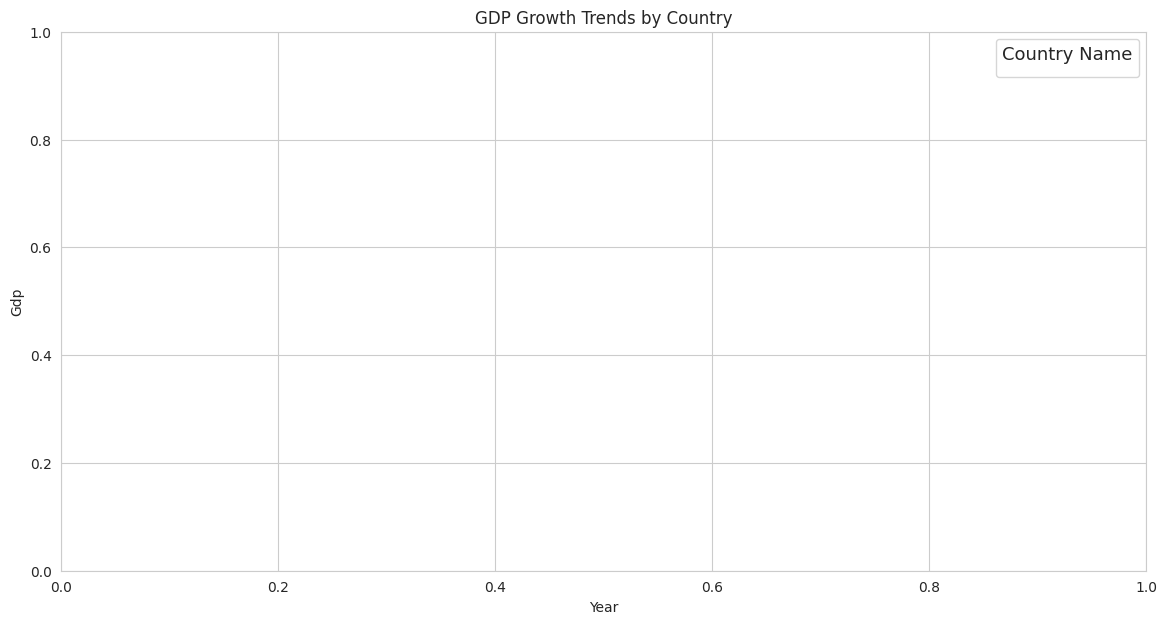

In [8]:
sns.set_style("whitegrid")

# Plotting
plt.figure(figsize=(14, 7))
sns.lineplot(x='Year', y='Gdp', hue='Country Name', data=country_data, marker='o')
plt.title('GDP Growth Trends by Country')
plt.xlabel('Year')
plt.ylabel('Gdp')
plt.legend(title='Country Name', title_fontsize='13', fontsize='11')
plt.show()

GDP percentage mean above 0 indicates the Country has a positive Growth Rate while mean below 0 indicates the country has negative Growth Rate while mean equal to 0 indicates a steady Growth Rate.

In [9]:
print(df2_melted['Gdp'].describe())

count    15982.000000
mean         3.541001
std          5.325447
min        -64.047107
25%          1.604880
50%          3.669126
75%          5.644078
max        149.972963
Name: Gdp, dtype: float64


Plotting mean GDP of all Countries

In [10]:
mean_gdp_per_country = df2_melted.groupby('Country Name')['Gdp'].mean()
mean_gdp_per_country = mean_gdp_per_country.reset_index()
mean_gdp_per_country.columns = ['Country Name', 'Mean GDP']
print(mean_gdp_per_country)

                    Country Name  Mean GDP
0                    Afghanistan  4.747960
1    Africa Eastern and Southern  3.241757
2     Africa Western and Central  3.628465
3                        Albania  2.984581
4                        Algeria  3.822778
..                           ...       ...
261           West Bank and Gaza  4.412233
262                        World  3.470214
263                  Yemen, Rep.  1.861577
264                       Zambia  3.317390
265                     Zimbabwe  2.883648

[266 rows x 2 columns]


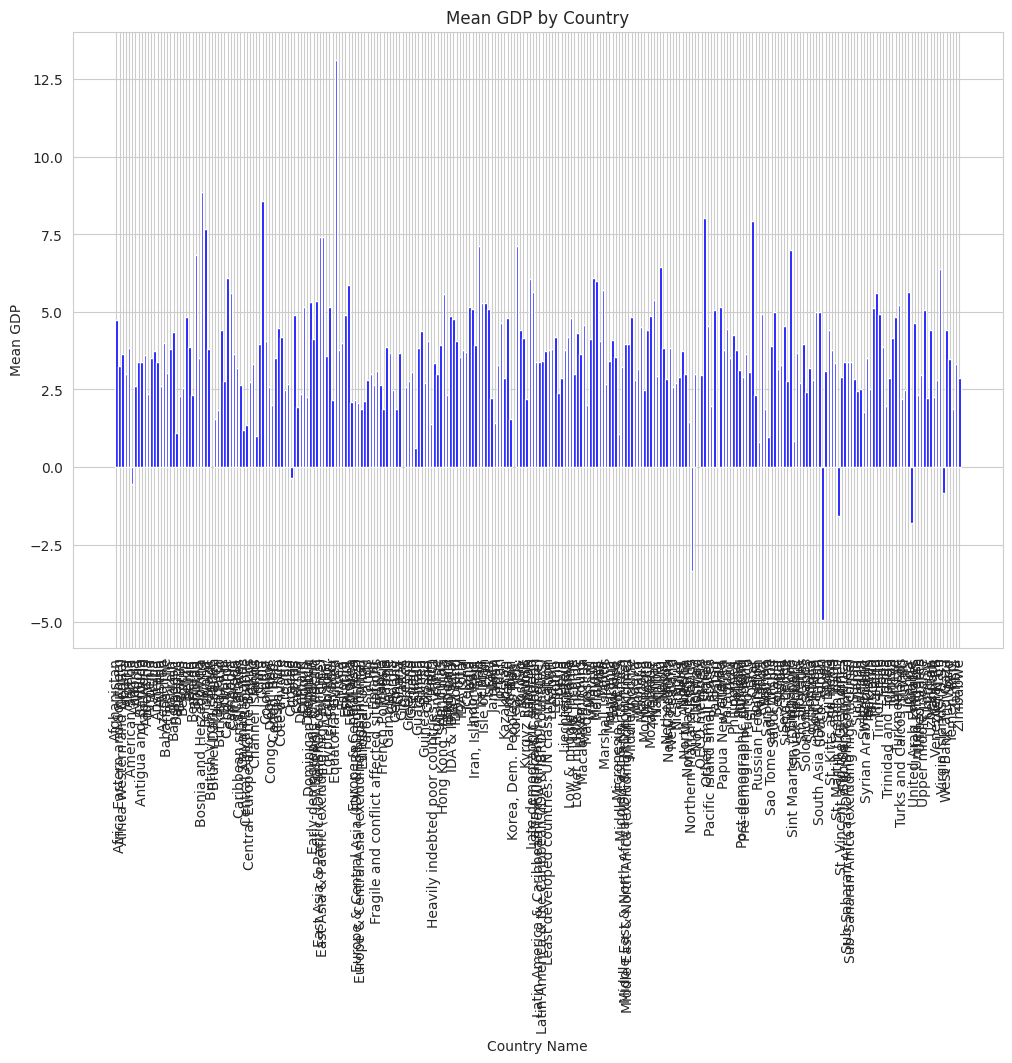

In [11]:
plt.figure(figsize=(12, 8))
plt.bar(mean_gdp_per_country['Country Name'], mean_gdp_per_country['Mean GDP'], color='blue')
plt.xlabel('Country Name')
plt.ylabel('Mean GDP')
plt.title('Mean GDP by Country')
plt.xticks(rotation=90)
plt.show()

Plotting the relation of percentage GDP change with percentage Capital Increase or Decrease.

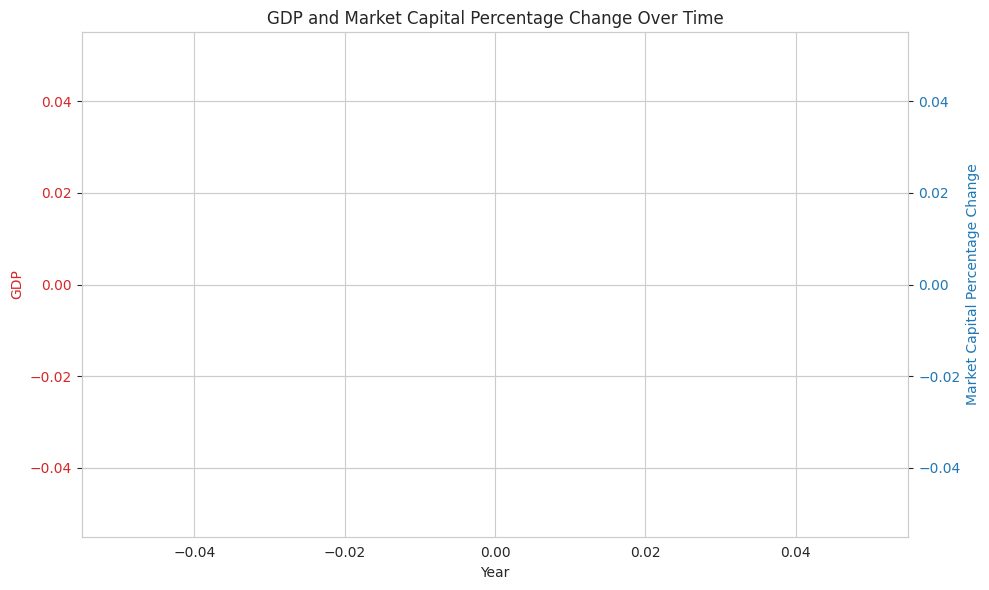

In [12]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('GDP', color=color)
ax1.plot(country_data['Year'], country_data['Gdp'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Market Capital Percentage Change', color=color)
ax2.plot(country_data['Year'], country_data['Percent_Change'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.title('GDP and Market Capital Percentage Change Over Time')
fig.tight_layout()
plt.show()


Now we will take the new Capital of the country for which we want to predict the GDP and use the percentage change of the new capital to the preceeding capital to evaluate the GDP for that year.

In [ ]:
def predict_gdp_change_with_new_capital():
    new_capital=float(input("Enter the new Capital"))
    last_capital = country_data['Capital'].iloc[-1]
    revenue_percentage_change = ((new_capital - last_capital) / last_capital) * 100
    predicted_gdp_change = model.predict([[revenue_percentage_change]])
    print("Capital Entered"+str(new_capital))
    if predicted_gdp_change>0:
        print("GDP is estimated to increase with Capital")
    else:
        print("GDP is estimated to decrease with Capital")
    print("estimated gdp is:")
    print(predicted_gdp_change[0])
    return
predict_gdp_change_with_new_capital()

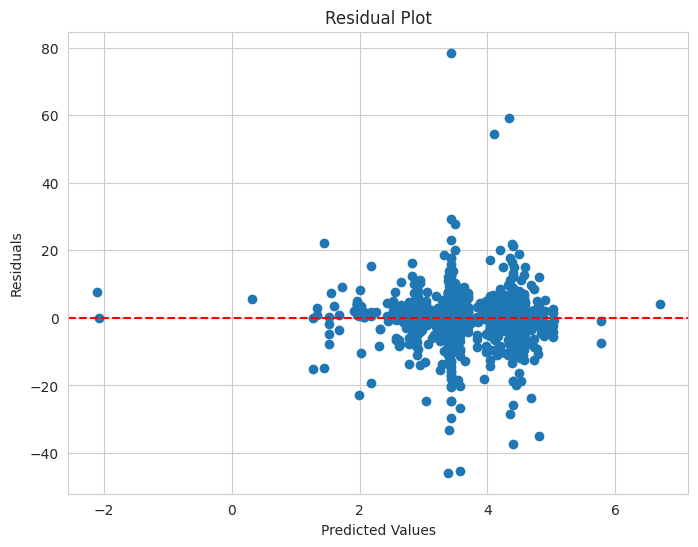

In [17]:
# Residual Plot
y_pred = model.predict(X_test)
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

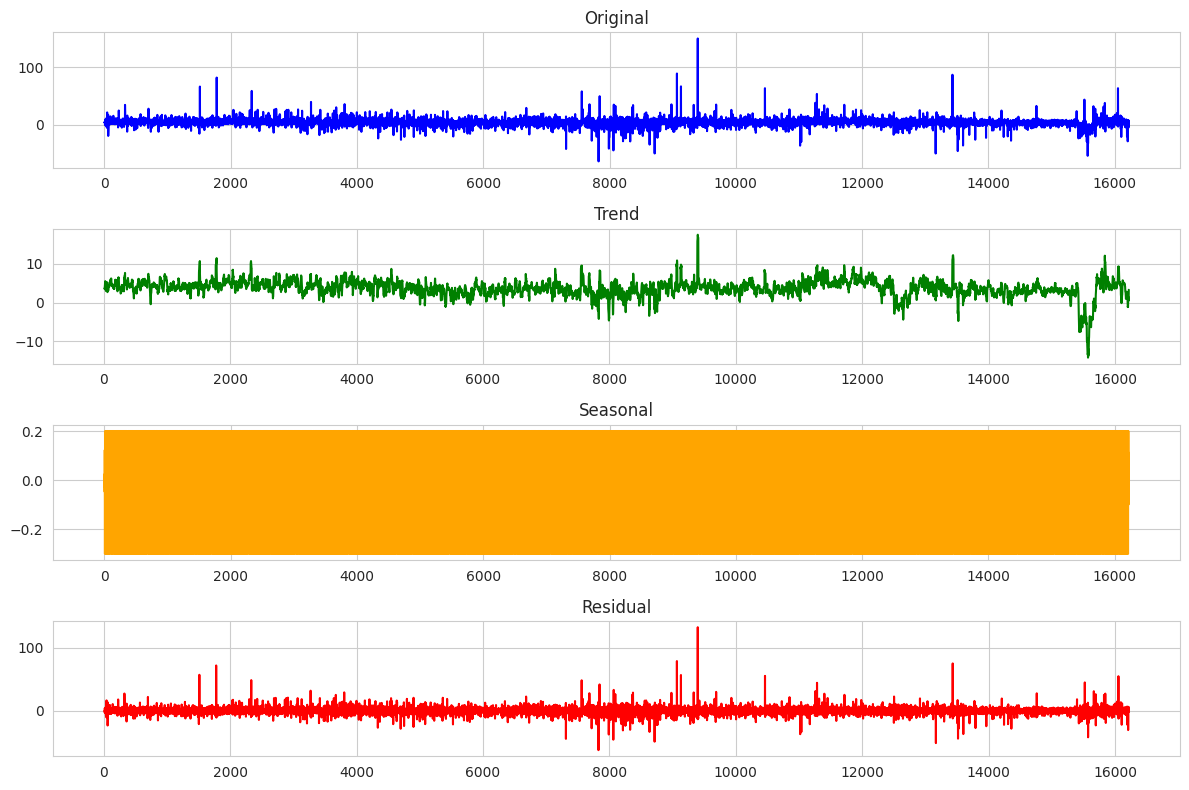

In [18]:
# Time Series Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(combined_df['Gdp'], period=12)
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(combined_df['Gdp'], label='Original', color='blue')
plt.title('Original')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='green')
plt.title('Trend')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='orange')
plt.title('Seasonal')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='red')
plt.title('Residual')
plt.tight_layout()
plt.show()


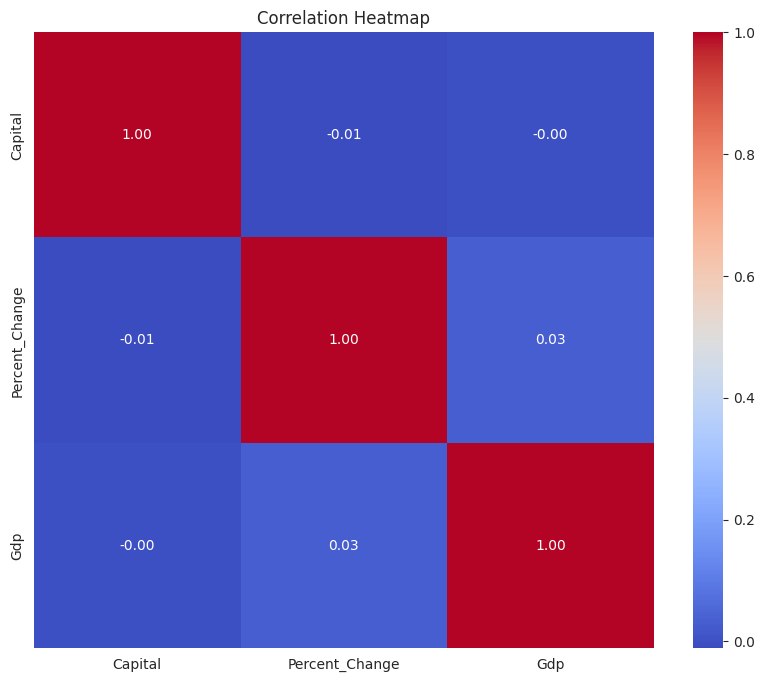

In [20]:
# Correlation Heatmap
numeric_columns = combined_df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = combined_df[numeric_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


In [21]:
# Model Performance Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_pred_train = model.predict(X_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
print(f'Training Set - MAE: {mae_train:.2f}, MSE: {mse_train:.2f}, R-squared: {r2_train:.2f}')

y_pred_test = model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print(f'Testing Set - MAE: {mae_test:.2f}, MSE: {mse_test:.2f}, R-squared: {r2_test:.2f}')


Training Set - MAE: 3.31, MSE: 30.84, R-squared: 0.08
Testing Set - MAE: 3.34, MSE: 33.01, R-squared: 0.01
